In [7]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'dataset/dogs-vs-cats-redux-kernels-edition/train'
TEST_DIR = 'dataset/dogs-vs-cats-redux-kernels-edition/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvcats-{}-{}.model'.format(LR, '6conv2-basic-video')


In [8]:
def lab_ling(img):
    try:
        word_label = img.split('.')[-3]
    except Exception:
        print(img)
    
    if word_label == 'cat':
        return [1,0]
    elif word_label == 'dog':
        return [0,1]

In [9]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = lab_ling(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), label])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [10]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        #label = lab_ling(img)
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.'[0])
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img)])
        
    np.save('test_data.npy', testing_data)
    return testing_data
        

In [11]:
train_data = create_train_data()

100%|██████████| 4183/4183 [00:03<00:00, 1091.16it/s]


In [12]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE,IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /content/clouderizer/mlbeginner/code/dogsvcats-0.001-6conv2-basic-video.model
model loaded!


In [14]:
train = train_data[:-500]
test = train_data[-500:]
len(train), len(test)

(3683, 500)

In [15]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [16]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 40899  | total loss: 0.00002 | time: 1.197s
| Adam | epoch: 010 | loss: 0.00002 - acc: 1.0000 -- iter: 3648/3683
Training Step: 40900  | total loss: 0.00002 | time: 2.218s
| Adam | epoch: 010 | loss: 0.00002 - acc: 1.0000 | val_loss: 0.00002 - val_acc: 1.0000 -- iter: 3683/3683
--


In [17]:
model.save(MODEL_NAME)

INFO:tensorflow:/content/clouderizer/mlbeginner/code/dogsvcats-0.001-6conv2-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 4698/4698 [00:04<00:00, 947.04it/s]


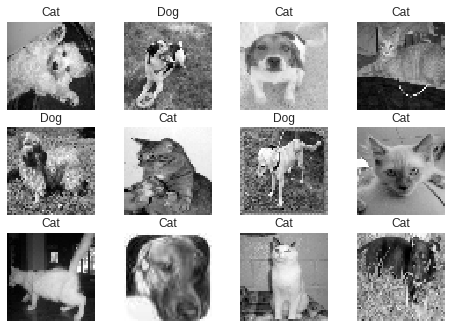

In [18]:
import matplotlib.pyplot as plt


#if don't have file yet

test_data = process_test_data()

#if data is present

#tets_data = np.load('test_data.npy')

fig = plt.figure()
for num,data in enumerate(test_data[:12]):
    
    #img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
        
    else:
        str_label = 'Cat'
        
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()
    


In [19]:
with open('sub-file.csv','w') as f:
    f.write('id,label\n')

In [20]:
with open('sub-file.csv','w') as f:
    for data in tqdm(test_data):
        
        img_num = data[0]
        img_data = data[1]
        
    
        y = fig.add_subplot(3,4,num+1)
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[0]))
        f.write('{},{}\n'.format(img_data, model_out[1]))
    
    

  0%|          | 0/4698 [00:00<?, ?it/s]


IndexError: list index out of range